### Hyperparameter Tuning

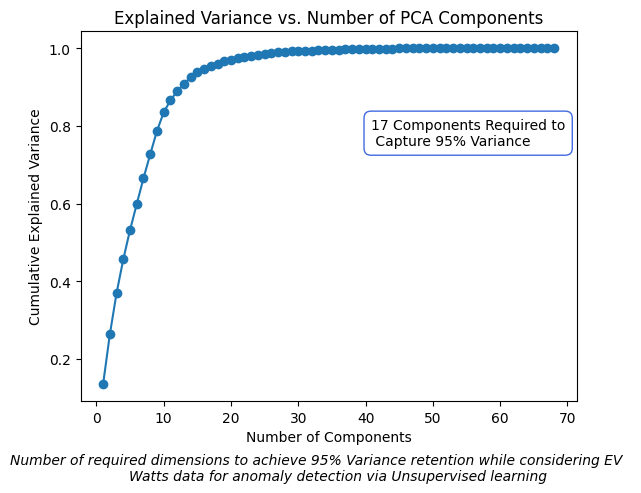

Sensitivity Analysis Finished in 0.5 minutes
Sensitivity Analysis Finished in 0.1 minutes


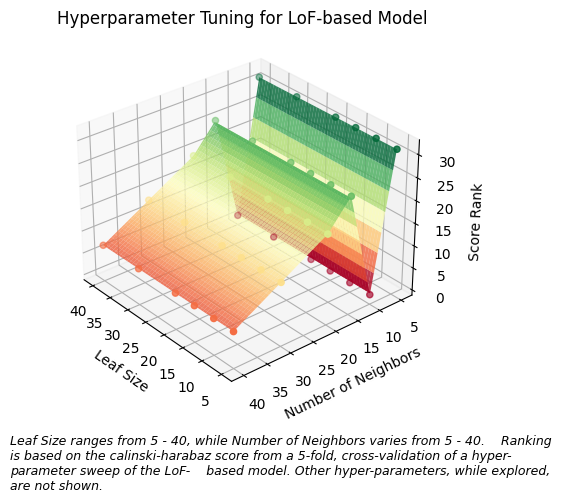

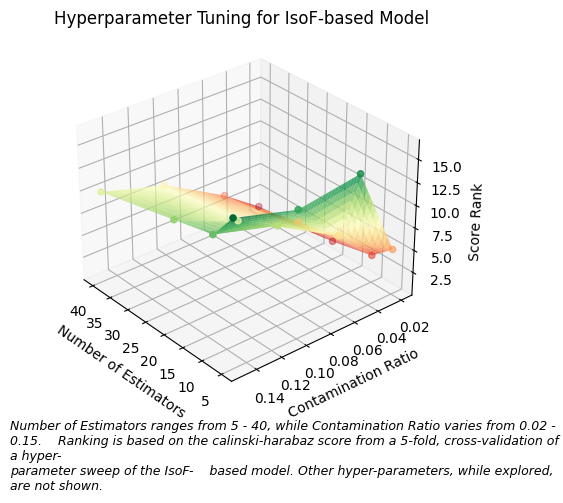

LOF Evaluation Finished in: 0.0 min
LOF Evaluation Finished in: 0.0 min


In [40]:
#Import general packages
import time
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

#model options: 
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM #very slow
from sklearn.neighbors import LocalOutlierFactor

#model eval packages
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import LocalOutlierFactor

#Import pyscripts 
import Unsupervised_Learning_V3


def evaluate_ISF(X_train, X_test, y_train, y_test, n_estimate=50, contam_ratio=0.2): 
    """
    This function builds an isolation forest model, based on the specified 
    training data, anomaly data, and number of samples. 

    INPUTS: 
    X_train: the training dataset using only non-anomalous data 
    X_anomalies: the anomaly dataset 
    n_samples: the number of samples to consider 
    n_estimate: the number of estimators used in the model (default to 100)

    OUTPUTS: 
    precision: the precision of the isolation forest model 
    recall: the recall of the isolation forest model 
    accuracy: the accuracy of the isolation forest model 
    """
    
    start = time.time()
    
    #Setup the model: 
    ISF = IsolationForest(n_estimators=n_estimate,contamination = contam_ratio)

    #Fit to the non-anomalous data
    ISF.fit(X_train)

    #Score performance               
    pred_train = ISF.predict(X_train)
    pred_test = ISF.predict(X_test)

    precision, recall, F1 = get_scores(pred_test, y_test)

    end = time.time()
    duration = np.round((end - start) / 60, 1)
    print(f"IsoF Evaluation Finished in: {duration} min")
    
    return precision, recall, F1 


def evaluate_LOF(X_train, X_test, y_train, y_test, n_neighbor= 5, n_leaf = 20, algorithm = "ball tree", p=1):
    start = time.time()
    
    # Initialize and fit Local Outlier Factor model
    lof = LocalOutlierFactor(novelty=True,
                             n_neighbors=n_neighbor,
                             leaf_size=n_leaf,
                             algorithm=algorithm,
                             p=p,
                             )
    
    lof.fit(X_train)
    
    # Predict on the training set and anomalies
    pred_train = lof.predict(X_train)
    pred_test = lof.predict(X_test)

    # Get performance
    precision, recall, F1 = get_scores(pred_test, y_test)
    
    end = time.time()
    duration = np.round((end - start) / 60, 1)
    print(f"LOF Evaluation Finished in: {duration} min")
    
    return precision, recall, F1 


def get_scores(input_prediction, input_data): 
    TP = np.sum((input_prediction == 1) & (input_data == 1))
    TN = np.sum((input_prediction == 0) & (input_data == 0))
    FP = np.sum((input_prediction == 1) & (input_data == 0))
    FN = np.sum((input_prediction == 0) & (input_data == 1))   

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * precision * recall / (precision + recall)  
    
    return precision, recall, F1
    

def lof_sensitivity_analysis(input_training_data, n_list = [5, 10, 20, 40], 
                             algorithm = ['ball_tree', 'kd_tree', 'brute'], 
                             leaf_size = [10, 30, 50],
                             p = [1,2]):
    
    """
    grid-search hyper-param tuning & sensitivty analysis for LoF model 
    
    INPUTS: 
    input_training data: a dataframe of the training data 
    n_list: the list of neighbor values (integers) to evaluate
    algorithm: the list of algorithms to use in the LoF (ball_tree, kd_tree, and/or brute) 
    leaf_size: the list of leaf numbers in the model (integer) 
    p: the distance measurement method (1 for manhattan, 2 for euclidean)
    
    OUTPUTS: 
    results: a pandas dataframe with the score for the different grid-search combinations
    """

    class LOF_grid_search(LocalOutlierFactor):
        """This class is used for hyper-parameter tuning of the LoF model for cluster analysis
        """
        def __init__(self, n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2):
            super().__init__(n_neighbors=n_neighbors, algorithm=algorithm, leaf_size=leaf_size, metric=metric, p=p)
    
        def fit(self, X, y=None):
            self.model = LocalOutlierFactor(
                n_neighbors=self.n_neighbors,
                algorithm=self.algorithm,
                leaf_size=self.leaf_size,
                metric=self.metric,
                p=self.p
            )
            self.model.fit(X)
            return self
    
        def score(self, X, y=None):
            y_pred = self.model.fit_predict(X)
            return calinski_harabasz_score(X, y_pred)
    
    
    param_grid = {
        'n_neighbors': n_list,
        'algorithm': algorithm,
        'leaf_size': leaf_size,
        'p': p  # Fixed parameter values to avoid 'p'
    }
    
    start = time.time()
    LOF_grid_search = LOF_grid_search()
    
    grid_search = GridSearchCV(estimator=LOF_grid_search, param_grid=param_grid, cv=5)
    grid_search.fit(input_training_data)
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    #clock performance & return results 
    end = time.time() 
    print(f"Sensitivity Analysis Finished in {np.round((end - start)/60,1)} minutes")
    return results


def IsoF_sensitivity_analysis(input_training_data, n_estim = [5, 10, 20, 40], 
                             contam_ratio = [0.02, 0.05, 0.1, 0.15],
                             ):
    
    """
    grid-search hyper-param tuning & sensitivty analysis for LoF model 
    
    INPUTS: 
    input_training data: a dataframe of the training data 
    n_estim: the list of number of estimators to use
    contam_ratio: the ratios of contamination in the training data 
    
    OUTPUTS: 
    results: a pandas dataframe with the score for the different grid-search combinations
    """


    class IsoF_grid_search(IsolationForest):
        """This class is used for hyper-parameter tuning of the IsoF model for cluster analysis
        """
        def __init__(self, n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0, bootstrap=False):
            super().__init__(n_estimators=n_estimators,contamination=contamination)
        
        def fit(self, X, y=None):
            self.model = IsolationForest(
                n_estimators = self.n_estimators,
                contamination=self.contamination,
            )
            self.model.fit(X)
            return self
        
        def score(self, X, y=None):
            y_pred = self.model.fit_predict(X)
            return calinski_harabasz_score(X, y_pred)

    
    param_grid = {
        'n_estimators': n_estim,
        'contamination': contam_ratio,
    }
    
    start = time.time()
    IsoF_grid_search = IsoF_grid_search()
    
    grid_search = GridSearchCV(estimator=IsoF_grid_search, param_grid=param_grid, cv=5)
    grid_search.fit(input_training_data)
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    #clock performance & return results 
    end = time.time() 
    print(f"Sensitivity Analysis Finished in {np.round((end - start)/60,1)} minutes")
    return results        
    

def hyper_parameter_plotting(input_df, model_type, col_x, col_y, col_z, x_name=None, y_name=None, z_name =None, fig_rotation=140): 
    """This function creates a 3D plot showing the sensitivty analysis for a model score against two hyper parameters
    INPUTS: 
    input_df: a pandas dataframe for ploting score vs. hyper params
    model_type: the type of model being evaluated
    col_x: hyper-parameter 1 to display
    col_y: hyper-parameter 2 to display
    col_z: the scoring column
    x_name: the string to name/label X dimension
    y_name: the string to name/label Y dimension
    z_name: the string to name/label Z dimension
    fig_rotation: the azimuth rotation angle for the plot

    OUTPUTS: none. A plt 3d plot is displayed 
    """
    
    
    X = input_df[col_x]
    Y = input_df[col_y]
    Z = input_df[col_z]

    if x_name == None: 
        x_name = col_x
    if y_name == None: 
        y_name = col_y
    if z_name == None: 
        z_name = col_z
    
    #Grid for plot contours: 
    xi = np.linspace(X.min(), X.max(), 100)
    yi = np.linspace(Y.min(), Y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((X, Y), Z, (xi, yi), method='linear')
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    norm = plt.Normalize(Z.min(), Z.max())
    colors = plt.cm.RdYlGn(norm(Z))  # Using the 'RdYlGn' colormap
    
    #surface map: 
    surface = ax.plot_surface(xi, yi, zi, cmap='RdYlGn', alpha=0.8)
    
    # Create scatter plot
    scatter = ax.scatter(X, Y, Z, c=colors, marker='o')
    
    # Setting labels
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_zlabel(z_name)
    ax.set_title(f"Hyperparameter Tuning for {model_type}-based Model")
    
    ax.view_init(elev=30, azim=fig_rotation)  # Adjust these values to change the angle
    
    plot_subtext = (f"{x_name} ranges from {X.min()} - {X.max()}, while {y_name} varies from {Y.min()} - {Y.max()}.\
    Ranking is based on the calinski-harabaz score from a 5-fold, cross-validation of a hyper-\nparameter sweep of the {model_type}-\
    based model. Other hyper-parameters, while explored, are not shown.") 
    
    plt.figtext(
        0.15, -0.07, plot_subtext, wrap=True, horizontalalignment='left', fontsize=9, fontstyle='italic',
    )
    
    plt.show()


def hyper_parameter_pipe(num_sample=1000):
    
    #Get training data for hyper-param analysis
    pca_X_train, pca_X_test, y_train, y_test, pca_X, y = Unsupervised_Learning_V3.get_data_pipe(num_sample=num_sample)

    #Set LoF hyper params to grid-search evaluate
    neighbor_list = [5, 10, 15, 20, 30, 40]
    algorithm_list = ['ball_tree']
    leaf_list = [5, 10, 15, 20, 30, 40]
    p_list = [1]

    #Set IsoF hyper params to grid-search evaluate
    n_estim_list = [5, 10, 20, 40]
    contam_ratio_list = [0.02, 0.05, 0.1, 0.15]
    
    #start clock (to help with HPC timing)
    start = time.time() 

    #run evaluation
    df_lof = lof_sensitivity_analysis(pca_X_train, n_list = neighbor_list, algorithm = algorithm_list, 
                                              leaf_size = leaf_list, p = p_list)

    df_isoF = IsoF_sensitivity_analysis(pca_X_train, n_estim = n_estim_list, contam_ratio = contam_ratio_list)

    #Sort by scores: 
    df_lof = df_lof.sort_values(by='rank_test_score', ascending=True).reset_index(drop=True)
    df_isoF = df_isoF.sort_values(by='rank_test_score', ascending=True).reset_index(drop=True)
        
    #plot results: 
    LoF_plot = hyper_parameter_plotting(df_lof, model_type="LoF", col_x="param_leaf_size", col_y="param_n_neighbors", 
                             col_z="rank_test_score", x_name = "Leaf Size", y_name = "Number of Neighbors", 
                             z_name = "Score Rank", fig_rotation=140)

    IsoF_plot = hyper_parameter_plotting(df_isoF, model_type="IsoF", col_x="param_n_estimators", col_y="param_contamination", 
                             col_z="rank_test_score", x_name = "Number of Estimators", y_name = "Contamination Ratio", 
                             z_name = "Score Rank", fig_rotation=140)

    #Now score the model for anomaly identification: 
    algo = df_lof["param_algorithm"].iloc[0]
    n_leaf = df_lof["param_leaf_size"].iloc[0]
    n_neighbor = df_lof["param_n_neighbors"].iloc[0]
    p_var = df_lof["param_p"].iloc[0]
    
    lof_precision, lof_recall, lof_F1 = evaluate_LOF(pca_X_train, 
                                                     pca_X_test, 
                                                     np.ravel(y_train), 
                                                     np.ravel(y_test), 
                                                     n_neighbor= n_neighbor, 
                                                     n_leaf = n_leaf, 
                                                     algorithm = algo, 
                                                     p=p_var,
                                                    )
    
    
    val_contam = df_isoF["param_contamination"].iloc[0]
    num_estimate = df_isoF["param_n_estimators"].iloc[0]
    
    IsoF_precision, IsoFrecall, IsoF1 = evaluate_ISF(pca_X_train, 
                                                     pca_X_test, 
                                                     np.ravel(y_train), 
                                                     np.ravel(y_test), 
                                                     n_estimate= num_estimate, 
                                                     contam_ratio = val_contam, 
                                                     )
    
    outputs = [IsoF_precision, IsoFrecall, IsoF1, lof_precision, lof_recall, lof_F1, df_lof, df_isoF, LoF_plot, IsoF_plot,
               pca_X_train, pca_X_test, y_train, y_test, pca_X, y]

    return outputs


if __name__ == "__main__": 
    results = hyper_parameter_pipe(num_sample=2000)
    IsoF_precision, IsoFrecall, IsoF1, lof_precision, lof_recall, lof_F1, df_lof, df_isoF, LoF_plot, IsoF_plot,pca_X_train, pca_X_test, y_train, y_test, pca_X, y = results

